In [ ]:
from z3 import *
import numpy as np
import re
import arviz as az
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()

from sat_metropolis import smt, mcmc, sat, utils

In [2]:
# Taken from (Simson Garfinkel, John M. Abowd, Christian Martindale. Understanding Database Reconstruction Attacks on Public Data. Communications of the ACM, March 2019, Vol. 62 No. 3, Pages 46-53. DOI: 10.1145/3287287)

# Assumption, all bit-vectors are of the same size
num_bits = 8
num_vars = 5*2 # (age, gender)
var_list = [BitVec(f'x{i}',num_bits) for i in range(num_vars)] # 0-4 age vars, 5-9 sex vars
x = var_list
g = Goal()
sat.add_bool_vars_to_goal(g, var_list)
g.add(sat.addition_does_not_overflow([x[0], x[1], x[2], x[3], x[4]]))
g.add(sat.addition_does_not_overflow([x[5], x[6], x[7], x[8], x[9]]))
for i in range(5):
    g.add(sat.multi_does_not_overflow([x[i],x[i+5]])) # this is in case of multiplication

# these are binary (obviously only for the purpose of the example)
# FEMALE = 0
# MALE = 1
for i in range(5,10):
    g.add(ULE(0,x[i]))
    g.add(ULE(x[i],1))


# establish an order to set the median
g.add(ULE(0,x[0]))
g.add(ULE(x[0],x[1]))
g.add(ULE(x[1],x[2]))
g.add(ULE(x[2],x[3]))
g.add(ULE(x[3],x[4]))
g.add(ULE(x[4],125))

g.add(x[2] == 30) # median

g.add(x[0] + x[1] + x[2] + x[3] + x[4] == 38*5) # average age

g.add(x[5] + x[6] + x[7] + x[8] + x[9] == 3) # only 3 males

g.add(x[0]*x[5] + x[1]*x[6] + x[2]*x[7] + x[3]*x[8] + x[4]*x[9] == 44*3) # average age of males

# NOTE: we might need to set an overflow constraint for the last sum.


In [3]:
trace = mcmc.sample_mh_trace_from_z3_model(backend='cmsgen',
                                           z3_problem=g,
                                           num_vars=num_vars,
                                           num_bits=num_bits,
                                           num_samples=10000, 
                                           num_chains=4)

c CMSGen Copyright Mate Soos (soos.mate@gmail.com)
c CMSGen SHA revision 422a9dbaba3f749c2df811d9dfab7ffd4627bac5
c CMSGen is MIT licensed
c CMSGen compilation env CMAKE_CXX_COMPILER = /usr/bin/c++ | CMAKE_CXX_FLAGS =  -mtune=native -Wall -Wextra -Wunused -Wsign-compare -fno-omit-frame-pointer -Wtype-limits -Wuninitialized -Wno-deprecated -Wstrict-aliasing -Wpointer-arith -Wpointer-arith -Wformat-nonliteral -Winit-self -Wparentheses -Wunreachable-code -ggdb3 -Wno-class-memaccess -Wlogical-op -Wrestrict -Wnull-dereference -Wdouble-promotion -Wshadow -Wformat=2 -Wextra-semi -pedantic | COMPILE_DEFINES =  -DUSE_GAUSS -DUSE_ZLIB -DYALSAT_FPU | STATICCOMPILE = OFF | ZLIB_FOUND = TRUE | VALGRIND_FOUND =  | ENABLE_TESTING =  | SLOW_DEBUG = OFF | ENABLE_ASSERTIONS = ON | MY_TARGETS =  | LARGEMEM =  | LIMITMEM =  | 
c CMSGen compiled with gcc version 13.2.0
c executed with command line: cmsgen --samples 10000 --samplefile cmsgen_input/cmsgen_samples.out cmsgen_input/z3_problem.cnf
c Writing sam

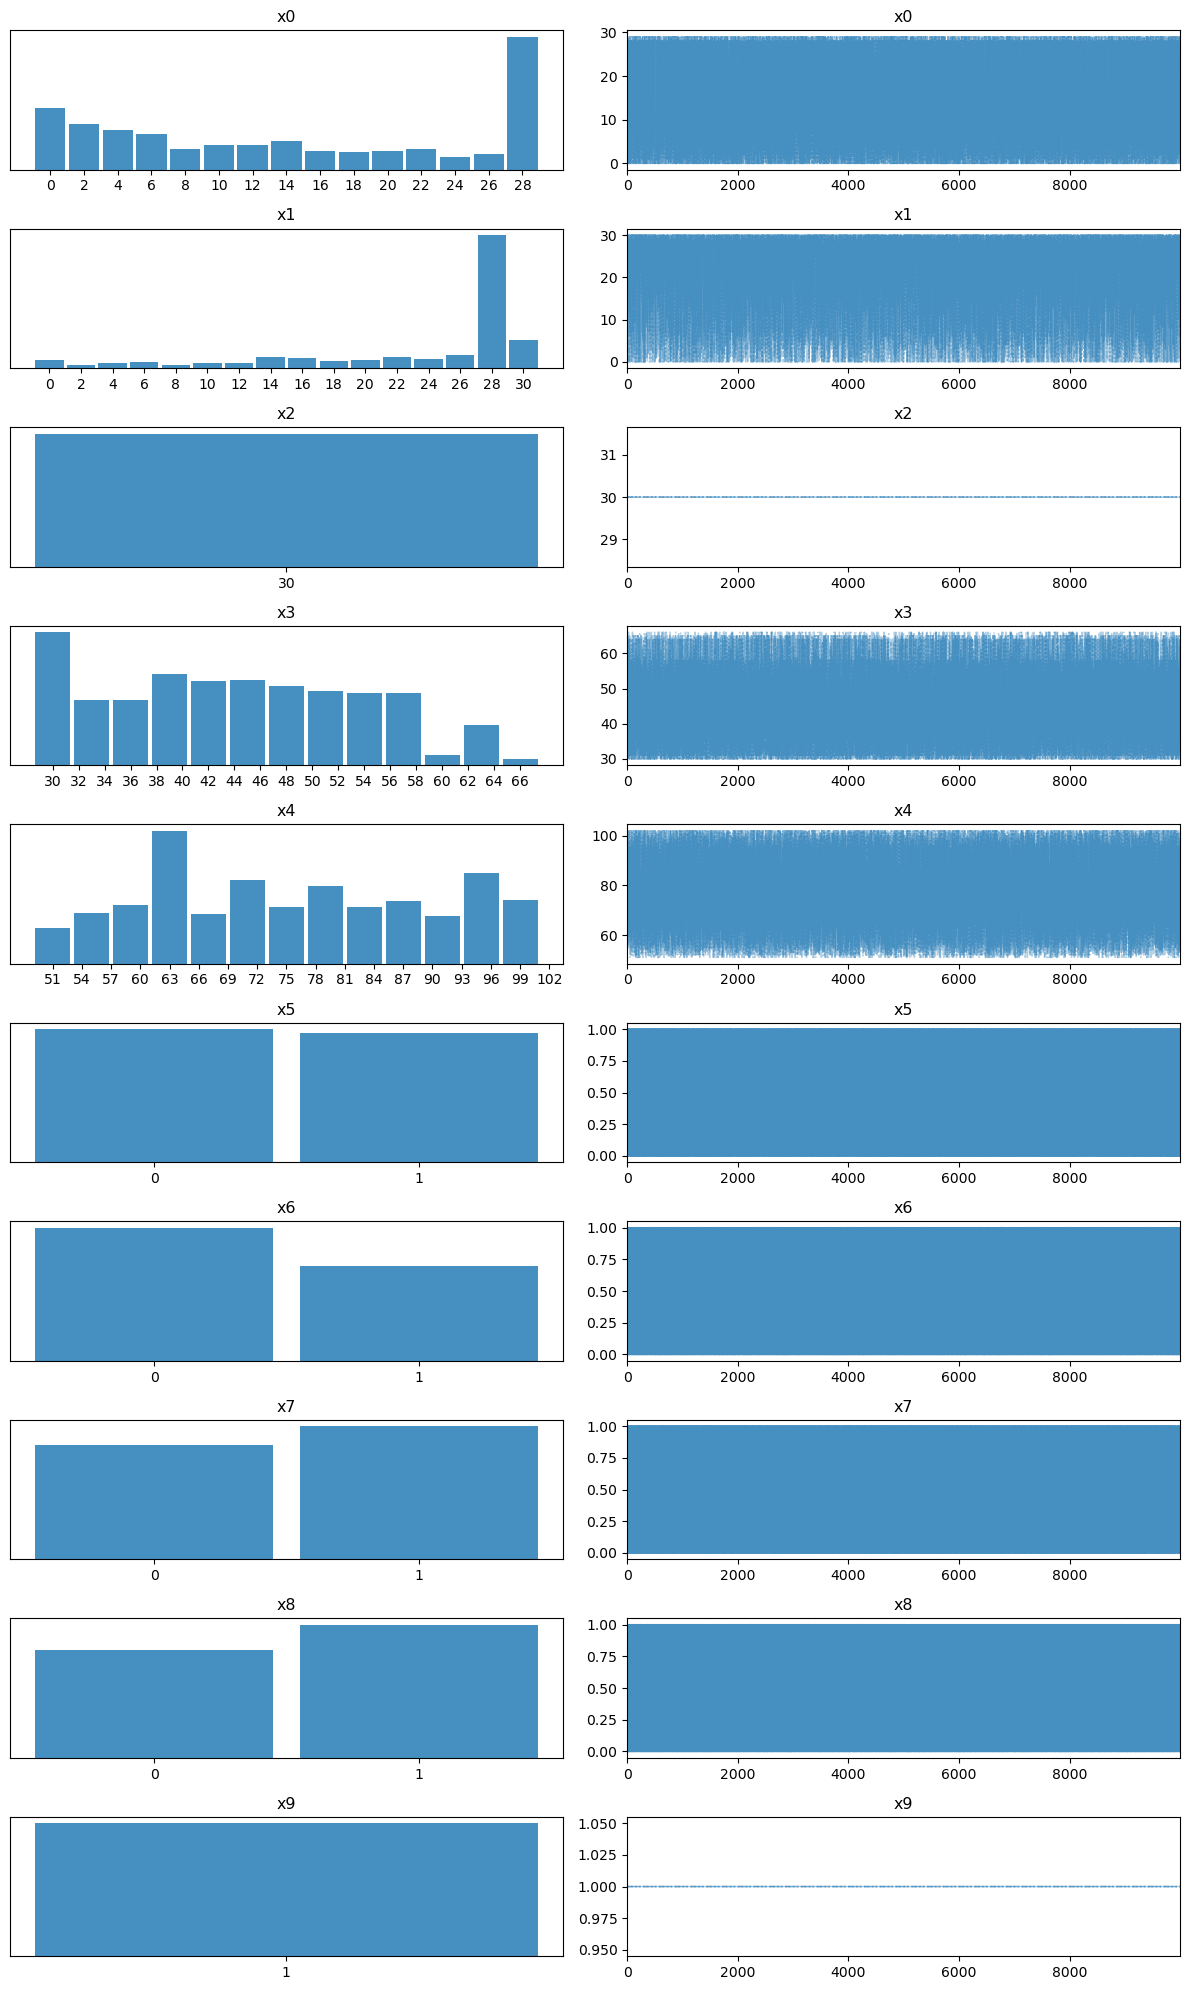

In [4]:
# Trace plot
az.plot_trace(trace);
plt.savefig('cmsgen_trace_plot.png', dpi=150);

In [5]:
# Diagnosis
az.summary(trace)

/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/pardo/programs/miniconda3/envs/mcmc_sat/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,14.808,10.503,0.0,28.0,0.053,0.037,40117.0,38926.0,1.0
x1,23.375,8.181,5.0,30.0,0.041,0.029,39774.0,40000.0,1.0
x2,30.000,0.000,30.0,30.0,0.000,0.000,40000.0,40000.0,NaN
x3,44.874,9.865,30.0,60.0,0.049,0.035,40016.0,39307.0,1.0
x4,76.943,14.409,56.0,102.0,0.073,0.051,39165.0,38138.0,1.0
x5,0.492,0.500,0.0,1.0,0.003,0.002,39466.0,39466.0,1.0
x6,0.417,0.493,0.0,1.0,0.002,0.002,39470.0,39470.0,1.0
x7,0.538,0.499,0.0,1.0,0.003,0.002,39520.0,39520.0,1.0
x8,0.553,0.497,0.0,1.0,0.002,0.002,40036.0,40000.0,1.0
x9,1.000,0.000,1.0,1.0,0.000,0.000,40000.0,40000.0,NaN


In [6]:
utils.save_trace(trace, f'db_cacm_SAT_cmsgen_{num_vars}_{num_bits}.nc')